In [4]:
import numpy as np
from scipy import optimize
from matplotlib import pyplot as plt

%matplotlib inline

e =np.e


Choosing a function to fit:
===========================
We'll try some sort of sigmoid function. Varies flavours of logistic function are often fitted to dose-response curves:

http://en.wikipedia.org/wiki/Generalised_logistic_function

The "smallest" variant of this that fits our data well takes 4 parameters:

\begin{equation*} f(t) = A + \frac{K - A}{1 + e^{-B(M-t)}} \end{equation*}

Where:
* A determines the lower asymptote
* K determines the upper asymptote. We'll fix this at 1.0 because we used normalized data that should top-out at that value.
* B determines the growth rate (think "gradient" or the transition)
* M determines the left/right position of the transititon.

Fixing the upper asymptote at one gives:

\begin{equation*} f(t) = A + \frac{1 - A}{1 + e^{-B(M-t)}} \end{equation*}

### Plotting this function...


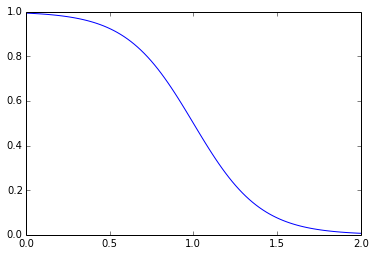

In [5]:
# first, define the logistic function...
def logistic_3_param(x, params):
    A, B, M = params
    return A + ((1.0- A)/(1+e**(-1*B*(M-x))))

# set up a numpy array of (arbitrary) x values to use
x = np.linspace(0,2,100)

# pick some values for A, B and M to use as our starting point: 
default_params= np.array([0.0, 5.0, 1])

# and let's plot that to check everything is working
plt.plot(x, logistic_3_param(x, default_params))
plt.show()


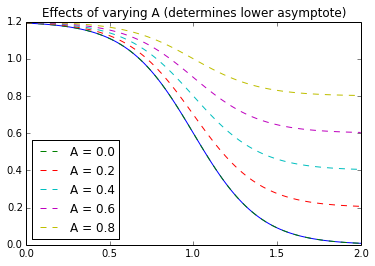

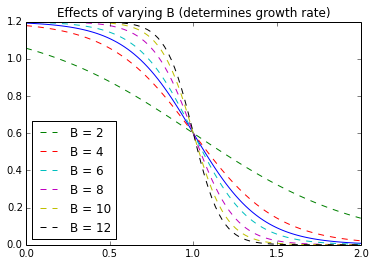

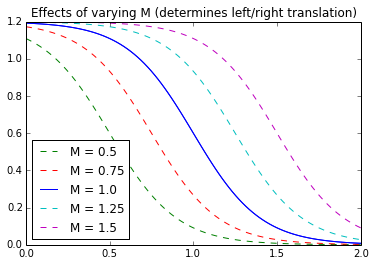

In [49]:
# OK, now try systematically changing the parameters to get a feel for the way the change the function

# plot changing A
plt.plot(x, logistic_3_param(x, default_params))
for A in np.arange(0,1,0.2):
    plt.plot(x,logistic_3_param(x, [A, 5.0, 1.0]), linestyle='--', label='A = ' + str(A))
plt.legend(loc=3)
plt.title('Effects of varying A (determines lower asymptote)')
plt.savefig('/home/mark/Desktop/A_change.png')
plt.show()

# plot changing B
plt.plot(x, logistic_3_param(x, default_params))
for B in np.arange(2,14,2):
    plt.plot(x,logistic_3_param(x, [0.0, B, 1.0]), linestyle='--', label='B = ' + str(B))
plt.legend(loc=3)
plt.title('Effects of varying B (determines growth rate)')
plt.savefig('/home/mark/Desktop/B_change.png')
plt.show()


# plot changing M
plt.plot(x, logistic_3_param(x, default_params))
for M in np.arange(0.5,1.75,0.25):
    if M == 1.0:
        plt.plot(x, logistic_3_param(x, default_params), 'b-', label = 'M = 1.0')
    else:        
        plt.plot(x,logistic_3_param(x, [0.0, 5.0, M]), linestyle='--', label='M = ' + str(M))
plt.legend(loc=3)
plt.title('Effects of varying M (determines left/right translation)')
plt.savefig('/home/mark/Desktop/M_change.png')
plt.show()


Fitting a function to real data:
================================
1. A quick look at some timecourse data...
-------------------------------------------
Here are some real data. This is the time-course of response of L4s to aldicarb at seven different concentrations. The data are from 30<sup>th</sup> September. The data have been normalized and are the mean values of 6 technical replicates. This is an old experimental design. Your data rely on biological replicates.



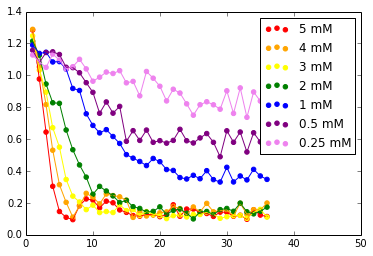

In [55]:
data = np.load('./Hw_ald_L4_30Nov14.npy')

concs = [5,4,3,2,1,0.5,0.25]
times = range(1, 37) # these times are just placeholders, not actual times

colors = ['red', 'orange', 'yellow', 'green', 'blue', 'purple','violet' ]

for i, c in enumerate(concs):
    plt.scatter(times, data[i], label =  str(c) + ' mM', color = colors[i])
    plt.plot(times, data[i], color = colors[i])

plt.legend(loc=1)
plt.axis([0,50,0,1.4])
plt.savefig('/home/mark/Desktop/ald_raw.png')
plt.show()

2. Fitting curves to the timecourse data...
-------------------------------------------
We have seven sets of time series data, one for each concentration. This means that we have seven separate curve fitting jobs. 
#### a) Set up the code for fitting
First, I'll set up a few functions we need to make it more convenient to use the least squares function in scipy... 


In [8]:


# First we need to define the function we'd like to fit.
# We'll use the same 3 parameter logistic we used above:
def logistic_3_param(x, params):
    A, B, M = params
    # Note upper asymptote changed from 1.0 to 1.2
    return A + ((1.2 - A)/(1+e**(-1*B*(M-x))))
    
    
# This is the function we want to minimise...
#   (AKA the "objective function")
#   Each time the least squares algorithm returns a
#   set of parameters, we look at the difference
#   between the real data and the function values
#   using those parameters.
def residuals(p, y, x):
    """Deviations of data from fitted  curve"""
    err = y - logistic_3_param(x, p)
    return err


def get_fit(response_data, time_points):
    p0 = [0.6,0.2, 9.0]  # initial parameter values
    plsq = optimize.leastsq(residuals, p0, args=(response_data,time_points))
    return  plsq[0] # return optimized parameter values

#### b) Try fitting a curve to one of the data series
Next, we'll use the least squares optimization method to fit the function to the time-series data for the 2 mM data

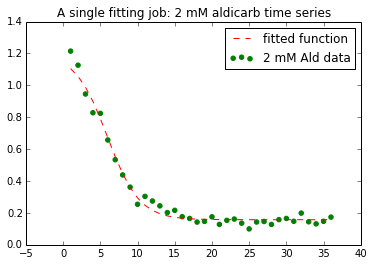

In [9]:
data_2mM = data[3]

fit_params_2mM = get_fit(data_2mM, times)

plt.plot(times, logistic_3_param(times, fit_params_2mM), 'r--', label = 'fitted function')
plt.scatter(times, data_2mM, label='2 mM Ald data', color='g')
plt.legend(loc=1)
plt.title('A single fitting job: 2 mM aldicarb time series')
plt.show()

#### c) Carry on and fit curves to the other time-series
So, the 4 mM fit doesn't look terrible and I bet abamectin will work even better. I'll go on and fit curves to the remaining time series...

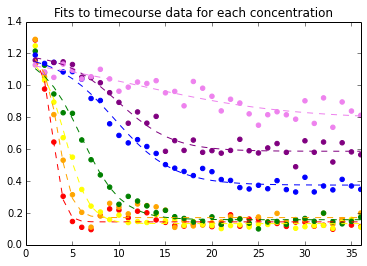

[[  0.14388502   1.76059275   2.92767835]
 [  0.17068933   1.33611741   3.48740424]
 [  0.1329738    0.79656171   4.26003875]
 [  0.15736059   0.46569467   5.94273798]
 [  0.37430648   0.31630484   9.54443215]
 [  0.58672391   0.34209113   9.96510751]
 [  0.78660446   0.12384968  12.5932339 ]]


In [58]:
fit_params_5mM = get_fit(data[0], times)
fit_params_4mM = get_fit(data[1], times)
fit_params_3mM = get_fit(data[2], times)
fit_params_2mM = get_fit(data[3], times) # same as in previous cell!
fit_params_1mM = get_fit(data[4], times)
fit_params_05mM = get_fit(data[5], times)
fit_params_025mM = get_fit(data[6], times)

fitted_params = np.vstack([fit_params_5mM,
                           fit_params_4mM,
                           fit_params_3mM,
                           fit_params_2mM,
                           fit_params_1mM,
                           fit_params_05mM,
                           fit_params_025mM])


for i, c in enumerate(concs):
    plt.scatter(times, data[i], label =  str(c) + ' mM',
                color = colors[i])
    plt.plot(times, logistic_3_param(times, fitted_params[i]),
             color = colors[i], linestyle='--')
plt.axis([0,36,0,1.4])
plt.title('Fits to timecourse data for each concentration')
plt.savefig('/home/mark/Desktop/ald_fits.png')
plt.show()

print fitted_params

3. Consider what this means...
------------------------------
This means that, at seven *specific* aldicarb concentrations, we can pick an arbitrary time and ask:

>"For this ***particular concentration*** of aldicarb, what is the expected response at time ***t*** ?"

This is progress but we can do more. Why limit ourselves to just those seven specific concentrations? Ultimately, we want to ask:

>"For ***any arbitrary concentration*** or aldicarb, ***c***, what is the expected response at time ***t*** ?"

We want a final model that gives us an expected response for any values of time or aldicarb concentration:

\begin{equation*} response = f(c,t)\end{equation*}





Bringing concentration into the model
=====================================

We currently have seven functions fitted to timecourse data at seven different concentrations. For each concentration, the fitted curve has a different set of parameters A, B and M. Let's have a look at them ...

In [11]:
print fitted_params
# Columns are A, B and M. 
# Rows are 5, 4, 3, 2, 1, 0.5 and 0.25 mM concentrations

[[  0.14388502   1.76059275   2.92767835]
 [  0.17068933   1.33611741   3.48740424]
 [  0.1329738    0.79656171   4.26003875]
 [  0.15736059   0.46569467   5.94273798]
 [  0.37430648   0.31630484   9.54443215]
 [  0.58672391   0.34209113   9.96510751]
 [  0.78660446   0.12384968  12.5932339 ]]


Notice that, as concentration decreases, moving down the rows:
1. A increases
2. B decreases
3. M increases

#### What are the mathematical functions that relate each of the three parameters to concentration?
Let's plot them...

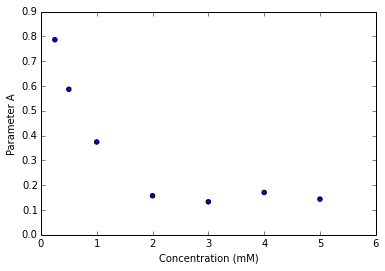

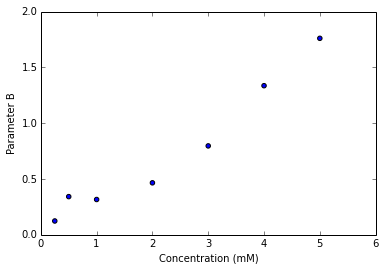

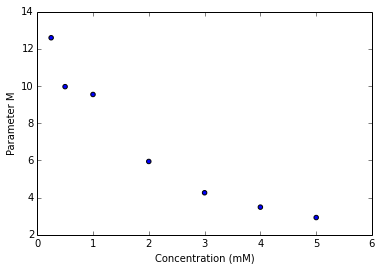

In [12]:
A = fitted_params[:,0]
B = fitted_params[:,1]
M = fitted_params[:,2]

plt.scatter(concs,A)
plt.xlabel('Concentration (mM)')
plt.ylabel('Parameter A')
plt.show()

plt.scatter(concs,B)
plt.xlabel('Concentration (mM)')
plt.ylabel('Parameter B')
plt.show()

plt.scatter(concs,M)
plt.xlabel('Concentration (mM)')
plt.ylabel('Parameter M')
plt.show()



To my eye (and this is still a bit subjective), it looks as if
* A is related to concentration by an exponental function
* B is related to concentration by a quadratic function
* M is related to a concentration by another quadratic function

Let's say that a generic exponential function looks like this:
\begin{equation*} f(x) = q +  e^{r(s-x)} \end{equation*}
...and a generic quadratic function looks like this:

\begin{equation*} g(x) = a{x^2} + b{x} + c \end{equation*}


Where x is concentration.

So, let's try fitting f(x) to the plot of A vs concentration and g(x) individually to the plots of B and M vs concentration.


In [43]:
def exp_decay(x, p):
    q, r, s = p
    return q + e**(r*(s-x))

def residuals_exp(p, y, x):
    """Deviations of data from fitted exponential function"""
    err = y-exp_decay(x, p)
    return err

def my_exp(y, concs):
    p0 = [-1,1, -1]
    plsq = optimize.leastsq(residuals_exp, p0, args=(y,concs))
    return  plsq[0]

##################################################################


def quadratic(x, p):
    a, b,c = p
    return (a*x**2) + b * x + c

def residuals_quad(p, y, x):
    """Deviations of data from fitted quadratic function"""
    err = y-quadratic(x, p)
    return err

def my_quad(y, concs, p0):
    # Will pass p0 as an argument because good initial 
    #   parameters might not be the same for fitting B and M  
    plsq = optimize.leastsq(residuals_quad,p0, args=(y,concs))
    return  plsq[0]




#### 1) Fitting A vs concentration:

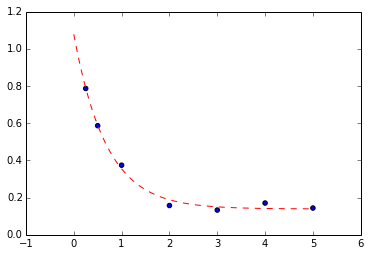

Fitted parameters:	[ 0.13897491  1.47157168 -0.04265371]


In [60]:
c_space = np.linspace(0,5,100)
A_fit = my_exp(fitted_params[:,0], concs)
plt.plot(c_space, exp_decay(c_space,A_fit), 'r--')
plt.scatter(concs,fitted_params[:,0])
plt.savefig('/home/mark/Desktop/A_fit.png')
plt.show()

print "Fitted parameters:\t", A_fit



This doesn't look too bad. So, plugging these parameters into our equation relating A to concentration:
\begin{equation*} A = 0.13897 +  e^{1.47158(-0.04265-conc)} \end{equation*}

#### 2) Fitting B vs concentration:

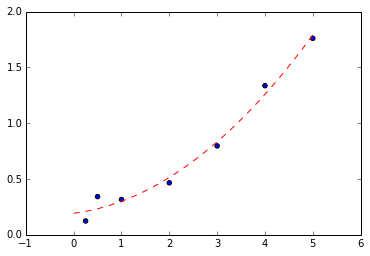

Fitted parameters:	[ 0.05295697  0.05469125  0.19294896]


In [61]:
concs = np.array(concs)

B_fit = my_quad(fitted_params[:,1], concs, [0.06,-2, 1])
plt.plot(c_space, quadratic(c_space,B_fit), 'r--')
plt.scatter(concs,fitted_params[:,1])
plt.savefig('/home/mark/Desktop/B_fit.png')

plt.show()

print "Fitted parameters:\t", B_fit




Again, this looks alright. Plugging our parameters into the quadratic function gives:

\begin{equation*} B = 0.05296{x^2} + 0.05469{x} + 0.19295 \end{equation*}

#### 2) Fitting M vs concentration:



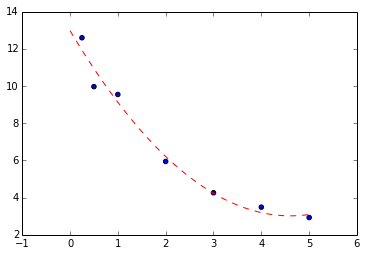

Fitted parameters:	[  0.46885889  -4.3220507   12.97988205]


In [62]:
M_fit = my_quad(fitted_params[:,2], concs, [0.5, -6, 18])

plt.plot(c_space, quadratic(c_space,M_fit), 'r--')
plt.scatter(concs,fitted_params[:,2])
plt.savefig('/home/mark/Desktop/M_fit.png')

plt.show()

print "Fitted parameters:\t", M_fit

This looks OK too. Plugging our parameters into the quadratic function gives:

\begin{equation*} M = 0.46886{x^2} - 4.32205{x} + 12.97988 \end{equation*}

We now have three expressions relating A, B and M to concentration. We can subsititute these into our function to get a function that takes *c* and *t* and to calculate an expected response:

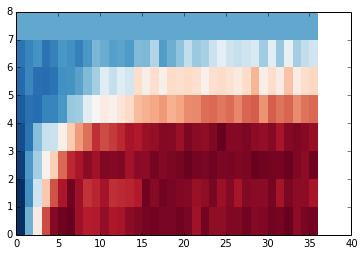

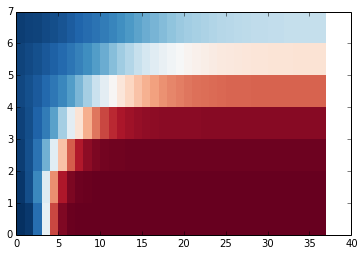

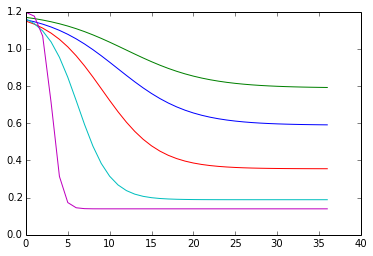

In [63]:
def ald_model(c_arr, t_arr):
    model = np.zeros([7,37])
    for i, c in enumerate(c_arr):
        for j, t in enumerate(t_arr):
            t=float(t)
            #print t
            K = 0.139 + e**(1.47*(-0.0426 - c))
            B = 0.05295697 * c**2 +  0.05469125 * c +  0.19294896
            M = 0.46885889 * c**2 - 4.3220507  * c +  12.97988205
            #print e**(-1*B*(M-t))
            #print K
            response = K + ((1.2 - K) / (1 + e**(-1 * B * (M - t))))
            #print response
            #print c, K,M,B, '\t', t, response
            model[i,j] = response
            
    return model
concs = np.array([5,4,3,2,1,0.5,0.25])

#t = np.arange(5,185,5).astype(float)

t = np.arange(0,37)
c = concs.astype(float)
#print concs
#print t

model = ald_model(c,t)
#plt.imshow(model)


plt.pcolor(data, cmap='RdBu')
plt.savefig('/home/mark/Desktop/model.png')
plt.show()
plt.pcolor(model, cmap='RdBu')
plt.savefig('/home/mark/Desktop/data.png')
plt.show()


plt.plot(t, model[5,:])
plt.plot(t, model[6,:])
plt.plot(t, model[4,:])
plt.plot(t, model[3,:])
plt.plot(t, model[0,:])


# See how parameters change between expts

In [ ]:
# L4s, aldicarb, 30 september
def wrangle_data(in_lines):
    data = np.zeros((8,12,50))
    block = []
    block_counter = 0
    for line in in_lines:
        line = line.strip()
        line = line.split('\t')
        if line == ['']:
            block = np.array(block, dtype=float)
            N2_data = block[:,:]
            data[:,:block.shape[1],block_counter] = N2_data
            block = []
            block_counter +=1
        else:    
            block.append(line)
    return data   


infile = open("/home/mark/data/img/2014/16dec/adult/adult_data_16dec.txt", 'rU')
data=infile.readlines()
infile.close()
data2 = wrangle_data(data)


Hw2 = data2[:,6:,:]
Hw2 = Hw2/Hw2[7,:,:]
Hw2 = Hw2.mean(axis=1)


infile = open("/home/mark/data/img/2014/17dec/adult/adult_data_17dec.txt", 'rU')
data=infile.readlines()
infile.close()
data3 = wrangle_data(data)

Hw3 = data3[:,6:,:]
Hw3 = Hw3/Hw3[7,:,:]
Hw3 = Hw3.mean(axis=1)

plt.pcolor(Hw[:,:35], cmap='RdBu')
plt.show()
plt.pcolor(Hw2[:,:35], cmap='RdBu')
plt.show()
plt.pcolor(Hw3[:,:35], cmap='RdBu')
plt.show()
plt.pcolor(model[:,:35], cmap='RdBu')
plt.show()


In [ ]:
def left_logistic(x, p_left):
    K2, B2, M2 = p_left
    return K2 + ((1.2- K2)/((1)+e**(-1*B2*(M2-x))))



def peval(x, p):
    """Evaluated logistic at x with current parameters."""
    return left_logistic(x, p)

def residuals(p, y, x):
    """Deviations of data from fitted 5PL curve"""

    err = y-left_logistic(x, p)
    return err



def my_drc(y, concs):
    p0 = [0.6,0.2, 9.0]  # try to make better guesses. Also, is is possible to restrain these in leastsq?
    plsq = optimize.leastsq(residuals, p0, args=(y,concs))
    return  plsq[0]



params_1 = np.zeros([7,3])
for i in range(0,7):
    fit = my_drc(Hw[i,:36], times)
    params_1[i,:] = fit

params_2 = np.zeros([7,3])
for i in range(0,7):
    fit = my_drc(Hw2[i,:36], times)
    params_2[i,:] = fit
    
params_3 = np.zeros([7,3])
for i in range(0,7):
    fit = my_drc(Hw3[i,:36], times)
    params_3[i,:] = fit
  
    
concs = np.array([5,4,3,2,1,0.5,0.25])
    
# plot ks
plt.scatter(concs, params_1[:,0])
plt.scatter(concs, params_2[:,0], color='r')    
plt.scatter(concs, params_3[:,0], color='g')  
plt.axis([0,5.5,0,1])
plt.show()

# plot bs
plt.scatter(concs, params_1[:,1])
plt.scatter(concs, params_2[:,1], color='r')    
plt.scatter(concs, params_3[:,1], color='g')
plt.axis([0,5.5,0,4])
plt.show()

# plot ms
plt.scatter(concs, params_1[:,2])
plt.scatter(concs, params_2[:,2], color='r')    
plt.scatter(concs, params_3[:,2], color='g')
plt.axis([0,5.5,0,14])
plt.show()
    

In [ ]:
# Hmmm, sort of noisy when done this way!

## Messing around with adding functions to model levamisole/aldicarb/nicotine etc

In [ ]:

x = np.linspace(1,10,200)
c1 =  ((1) / ((1 + 1*e**(-1*1*(x-7)))** (1 / 1)))
c2 =  ((1) / ((1 + 1*e**(-1*1*(-x+5)))** (1 / 1)))


plt.plot(x,c1)
plt.plot(x,c2)
plt.plot(x, c1+c2)
plt.show()


In [ ]:
x = np.linspace(1,12,200)
c1 =  ((1) / ((1 + 1*e**(-1*1*(x-7)))** (1 / 1)))
c2 =  ((1) / ((1 + 1*e**(-1*1*(-x+5)))** (1 / 1)))



for i in range(6, 12):
    offset = i / 4.0
    c1 =  ((1) / ((1 + 1*e**(-1*1*(x-9+ offset)))** (1 / 1)))
    #plt.plot(x,c1)
    plt.plot(x, c1+c2, 'r')
    plt.plot(x,c1, 'g--')
    

plt.plot(x,c2, 'b--')
plt.show()


c1 =  ((1) / ((1 + 1*e**(-1*1*(x-7)))** (1 / 1)))
c2 =  0.3 +(0.7 / ((1 + 1*e**(-1*1*(-x+5)))** (1 / 1)))


for i in range(1,6):
    offset = i / 12.0
    c1 =  ((1) / ((1+offset + 1*e**(-1*1*(x-9+2.5)))** (1 / 1)))
    c2 =  offset +((1-offset)/ ((1 + 1*e**(-1*1*(-x+5)))** (1 / 1)))

    #plt.plot(x,c1)
    plt.plot(x, c1+c2, 'r')
    plt.plot(x,c1, 'g--')
    plt.plot(x,c2, 'b--')




# ^ 3 params works well for simple sigmoidal response. Now try 3 + 3 params for biphasic response

In [1]:
def right_logistic(x, p_right):
    K1, B1,M1 = p_right
    return (K1/(1+e**(-1*B1*(x-M1))))


def left_logistic(x, p_left):
    K2, B2, M2 = p_left
    return K2 + ((1.1- K2)/((1)+e**(-1*B2*(M2-x))))




def my_func(x,p):
    K1, B1, M1, K2, B2, M2 = p
    return left_logistic(x, p[3:]) + right_logistic(x,p[:3])

def peval(x, p):
    """Evaluated logistic at x with current parameters."""
    return my_func(x, p)

def residuals(p, y, x):
    """Deviations of data from fitted 5PL curve"""

    err = y-my_func(x, p)
    return err



def my_drc(y, concs):
    p0 = [0.6,0.2, 9.0, 0.2,0.6,9.0]  # try to make better guesses. Also, is is possible to restrain these in leastsq?
    plsq = optimize.leastsq(residuals, p0, args=(y,concs))
    return  plsq[0]

In [2]:
t = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 
     65, 70, 75, 80, 85, 90, 95, 100]
r = [0.94773187, 0.74324197, 0.54686632, 0.41150906,  0.27816171,  0.25186665,
     0.30685065, 0.38373975,  0.412437, 0.43991783,  0.48188417,  0.55894796,
     0.5656137,  0.62702125,  0.67608837,  0.75669813,  0.75488602,  0.80078237,
  0.79110718,  0.83367024]

my_fit_2  =my_drc(r,t)

print my_fit_2

t2 = np.linspace(0,100,200)

plt.plot(t2, peval(t2,my_fit_2))
plt.scatter(t,r)
plt.plot(t2, left_logistic(t2, my_fit_2[3:]), 'r-')
plt.plot(t2, right_logistic(t2, my_fit_2[:3]), 'g-')

plt.axis([0,100,0,1])

NameError: global name 'optimize' is not defined

In [3]:
a=1
b=1
c=1
x = np.array([1,2,3,4,5,6,7])
q = a*np.power(x,2)+ b* x + c
print q

NameError: name 'np' is not defined

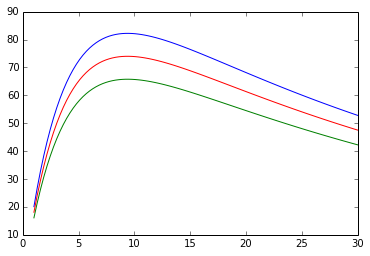

In [89]:
def indirect_model(dose,time, k1=0.29, k2 = 0.026):
    D = dose
    T = 0.5
    t = time
    V=86
    
    
    p = (((np.e**(k1*T)) - 1)* np.e ** (-1*k1*t)) / (k1 * (k2-k1))
    q = (((np.e ** (k2*T)) -1)*np.e ** (-1*k2*t)) / (k2 * (k1-k2))
    m = ((D/T) * 1000 * k2) / V
    response = m * (p + q)
    return response
    
time = np.linspace(1,30,100)

dose = 100
response = indirect_model(dose,time)
plt.plot(time, response)

dose = 80
response = indirect_model(dose,time)
plt.plot(time, response)

dose = 90
response = indirect_model(dose,time)
plt.plot(time, response)